In [1]:
%cd /content/drive/MyDrive/딥러닝2권/2권/06GatedRNN

/content/drive/MyDrive/딥러닝2권/2권/06GatedRNN


In [ ]:
# RNN은 기울기 소실이나 기울기 폭발이 발생

### 6.1.4 기울기 클리핑(기울기 폭발 대책)

In [ ]:
import numpy as np

In [ ]:
# 모든 매개변수의 기울기를 한번에 처리
def clip_grads(grads, max_norm): # grads: 리스트 형태의 기울기, max_norm: threshold 값
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    tatal_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6.2 LSTM

In [ ]:
# forget gate -> input gate -> output gate 순으로.
'''
기억 셀의 역전파는 x 와 + 만 지나게 되는데,
x에서는 매 시각 다른 게이트 값을 이용해 원소별 곱을 진행하기에 곱셈의 효과가 누적되지 않음.
따라서 기울기 소실이 일어나기 어려움
그리고 원소별 곱이라서 잊어야 하는 셀에 대해서는 기울기가 작아지고, 기억해야 되는 원소에 대해서는 기울기가 작아지지 않음.
'''

'\n기억 셀의 역전파는 x 와 + 만 지나게 되는데,\nx에서는 매 시각 다른 게이트 값을 이용해 원소별 곱을 진행하기에 곱셈의 효과가 누적되지 않음.\n따라서 기울기 소실이 일어나기 어려움\n그리고 원소별 곱이라서 잊어야 하는 셀에 대해서는 기울기가 작아지고, 기억해야 되는 원소에 대해서는 기울기가 작아지지 않음.\n'

## 6.3 LSTM 구현

In [ ]:
import sys
sys.path.append('..')
from common.functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # 4개분의 가중치가 모두 담김
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # slicing
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:4*H]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i # forget + input
        h_next = o * np.tanh(c_next) # output

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)

        return h_next, c_next


    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2) # c_next에서 분기된 거 역전파

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i) # sigmoid 역전파
        df *= f * (1 - f) # sigmoid 역전파
        do *= o * (1 - o) # sigmoid 역전파
        dg *= (1 - g ** 2) # tanh 역전파

        dA = np.hstack((df, dg, di, do)) # slicing 역전파

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### Time LSTM 구현

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='i')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0  # 이전 LSTM에서 역전파된 dh, dc를 담기 위해서 0으로 초기화

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad # LSTM 레이어의 Wx, Wh, b는 동일해서 한번에 더해서 update 해줘야..

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        self.dh = dh

        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

In [ ]:
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치
        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 가중치 모아두기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)

        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)

        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

### 학습

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.00
| 에폭 1 |  반복 21 / 1327 | 시간 10[s] | 퍼플렉서티 2333.42
| 에폭 1 |  반복 41 / 1327 | 시간 21[s] | 퍼플렉서티 1303.56
| 에폭 1 |  반복 61 / 1327 | 시간 33[s] | 퍼플렉서티 1102.96
| 에폭 1 |  반복 81 / 1327 | 시간 44[s] | 퍼플렉서티 976.76
| 에폭 1 |  반복 101 / 1327 | 시간 54[s] | 퍼플렉서티 895.97
| 에폭 1 |  반복 121 / 1327 | 시간 64[s] | 퍼플렉서티 904.73
| 에폭 1 |  반복 141 / 1327 | 시간 76[s] | 퍼플렉서티 877.81
| 에폭 1 |  반복 161 / 1327 | 시간 87[s] | 퍼플렉서티 841.19
| 에폭 1 |  반복 181 / 1327 | 시간 98[s] | 퍼플렉서티 869.45
| 에폭 1 |  반복 201 / 1327 | 시간 107[s] | 퍼플렉서티 798.35
| 에폭 1 |  반복 221 / 1327 | 시간 119[s] | 퍼플렉서티 825.62
| 에폭 1 |  반복 241 / 1327 | 시간 130[s] | 퍼플렉서티 803.22
| 에폭 1 |  반복 261 / 1327 | 시간 141[s] | 퍼플렉서티 842.46
| 에폭 1 |  반복 281 / 1327 | 시간 151[s] | 퍼플렉서티 816.26
| 에폭 1 |  반복 301 / 1327 | 시간 162[s] | 퍼플렉서티 788.16
| 에폭 1 |  반복 321 / 1327 | 시간 173[s] | 퍼플렉서티 699.43
| 에폭 1 |  반복 341 / 1327 | 시간 184[s] | 퍼플렉서티 769.89
| 에폭 1 |  반복 361 / 1327 | 시간 195[s] | 퍼플렉서티 835.51
| 에폭 1 |  반복 381 / 1327 | 시간 206[s] | 퍼플렉서티

/content/drive/MyDrive/딥러닝2권/2권/06GatedRNN/../common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


| 에폭 2 |  반복 1061 / 1327 | 시간 1288[s] | 퍼플렉서티 451.62
| 에폭 2 |  반복 1081 / 1327 | 시간 1298[s] | 퍼플렉서티 419.03
| 에폭 2 |  반복 1101 / 1327 | 시간 1309[s] | 퍼플렉서티 438.54
| 에폭 2 |  반복 1121 / 1327 | 시간 1320[s] | 퍼플렉서티 505.01
| 에폭 2 |  반복 1141 / 1327 | 시간 1331[s] | 퍼플렉서티 465.30
| 에폭 2 |  반복 1161 / 1327 | 시간 1340[s] | 퍼플렉서티 475.34
| 에폭 2 |  반복 1181 / 1327 | 시간 1351[s] | 퍼플렉서티 451.36
| 에폭 2 |  반복 1201 / 1327 | 시간 1362[s] | 퍼플렉서티 400.68
| 에폭 2 |  반복 1221 / 1327 | 시간 1373[s] | 퍼플렉서티 399.21
| 에폭 2 |  반복 1241 / 1327 | 시간 1383[s] | 퍼플렉서티 456.62
| 에폭 2 |  반복 1261 / 1327 | 시간 1394[s] | 퍼플렉서티 420.45
| 에폭 2 |  반복 1281 / 1327 | 시간 1405[s] | 퍼플렉서티 430.92
| 에폭 2 |  반복 1301 / 1327 | 시간 1416[s] | 퍼플렉서티 511.28
| 에폭 2 |  반복 1321 / 1327 | 시간 1426[s] | 퍼플렉서티 483.44
| 에폭 3 |  반복 1 / 1327 | 시간 1430[s] | 퍼플렉서티 472.24
| 에폭 3 |  반복 21 / 1327 | 시간 1440[s] | 퍼플렉서티 488.09
| 에폭 3 |  반복 41 / 1327 | 시간 1450[s] | 퍼플렉서티 459.44
| 에폭 3 |  반복 61 / 1327 | 시간 1463[s] | 퍼플렉서티 438.04
| 에폭 3 |  반복 81 / 1327 | 시간 1474[s] | 퍼플렉서티 420.04
| 에폭

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

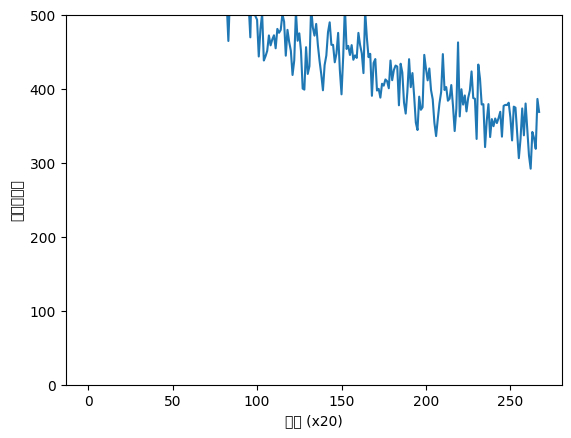

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  372.28206267911065


In [ ]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from common import config

config.GPU = True # gpu 활용

# hyper parameter
batch_size = 20
wordvec_size = 100
hidden_size = 100  # lstm hidden state
time_size = 35  # lstm input words
lr = 20.0
max_epoch = 4
max_grad = 0.25 # gradient clipping

# data load
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

model.save_params()

## 6.5 RNNLM 추가 개선

In [2]:
import sys
sys.path.append('..')

In [4]:
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale
            # 남아있는 값들에 scale을 곱해서 크기를 유지

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask

In [5]:
# LSTM 레이어 여러 개
# Dropout(깊이 방향으로) (FFNN보다 RNN이 과적합이 더 쉽게 일어남)
# 가중치 공유: Affine과 임베딩 계층의 가중치를 같게
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx1 = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 *H)/np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(D, 4*H)/np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 *H)/np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []

        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)

        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)

        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.71
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 2626.14
| 에폭 1 |  반복 41 / 1327 | 시간 10[s] | 퍼플렉서티 1270.81
| 에폭 1 |  반복 61 / 1327 | 시간 15[s] | 퍼플렉서티 1016.00
| 에폭 1 |  반복 81 / 1327 | 시간 19[s] | 퍼플렉서티 922.30
| 에폭 1 |  반복 101 / 1327 | 시간 25[s] | 퍼플렉서티 803.88
| 에폭 1 |  반복 121 / 1327 | 시간 30[s] | 퍼플렉서티 773.22
| 에폭 1 |  반복 141 / 1327 | 시간 34[s] | 퍼플렉서티 699.99
| 에폭 1 |  반복 161 / 1327 | 시간 40[s] | 퍼플렉서티 698.76
| 에폭 1 |  반복 181 / 1327 | 시간 45[s] | 퍼플렉서티 701.06
| 에폭 1 |  반복 201 / 1327 | 시간 49[s] | 퍼플렉서티 622.52
| 에폭 1 |  반복 221 / 1327 | 시간 55[s] | 퍼플렉서티 601.79
| 에폭 1 |  반복 241 / 1327 | 시간 60[s] | 퍼플렉서티 561.03
| 에폭 1 |  반복 261 / 1327 | 시간 65[s] | 퍼플렉서티 608.33
| 에폭 1 |  반복 281 / 1327 | 시간 70[s] | 퍼플렉서티 568.11
| 에폭 1 |  반복 301 / 1327 | 시간 75[s] | 퍼플렉서티 506.78
| 에폭 1 |  반복 321 / 1327 | 시간 81[s] | 퍼플렉서티 452.19
| 에폭 1 |  반복 341 / 1327 | 시간 85[s] | 퍼플렉서티 517.12
| 에폭 1 |  반복 361 / 1327 | 시간 89[s] | 퍼플렉서티 536.23
| 에폭 1 |  반복 381 / 1327 | 시간 96[s] | 퍼플렉서티 463.35
| 에폭

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

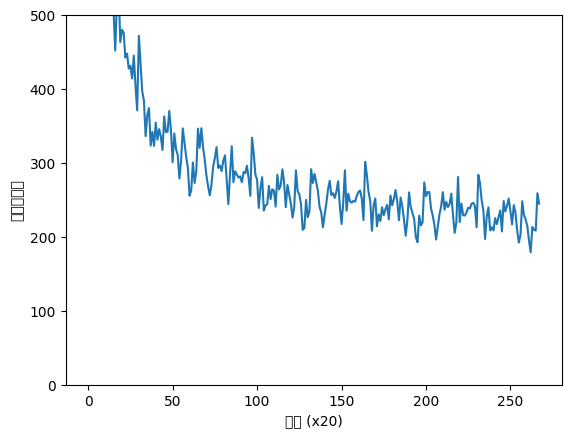

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  179.4035163179325


In [10]:
## 위의 RNNLM과 동이한 환경에서 테스트

from common.trainer import RnnlmTrainer

config.GPU = True # gpu 활용

# hyper parameter
batch_size = 20
wordvec_size = 100
hidden_size = 100  # lstm hidden state
time_size = 35  # lstm input words
lr = 20.0
max_epoch = 4
max_grad = 0.25 # gradient clipping
dropout = 0.5

# data load
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

model.save_params('better.pkl')

In [ ]:
# 에포크나 모델 복잡도(hidden state 뉴런 수) 등을 늘리지 않아도 퍼플렉서티가 매우 올라감.

### 검증

In [6]:
from common import config
from common.optimizer import SGD
from common.util import eval_perplexity, to_gpu
from dataset import ptb

config.GPU = True

# hyper_parameter
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
dropout = 0.5

# data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)

# 테스트 데이터로 평가
model.reset_state()
model.load_params('BetterRnnlm.pkl') # 학습 시간의 문제로 저장된 파라미터 불러옴
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

Done
퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  75.76414190129441


## 6.6 GRU

In [18]:
class GRU:
    def __init__(self, Wx, Wh):
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None
        self.params = [self.Wx, self.Wh]
        self.grads = [np.zeros_like(self.Wx), np.zeros_like(self.Wh)]

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:] # LSTM과는 달리 X, Z, R에 해당하는 3개의 가중치가 존재
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev

In [16]:
class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        self.params = [self.Wx, self.Wh]
        self.grads = [np.zeros_like(self.Wx), np.zeros_like(self.Wh)]

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

In [13]:
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss
import pickle

class GRUlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치
        embed_W = (rn(V, D)/100).astype('f')
        gru_Wx = (rn(D, 3*H) / np.sqrt(D)).astype('f')
        gru_Wh = (rn(H, 3*H) / np.sqrt(H)).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeGRU(gru_Wx, gru_Wh, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 가중치 모아두기
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)

        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)

        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9996.71
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2046.07
| 에폭 1 |  반복 41 / 1327 | 시간 9[s] | 퍼플렉서티 1035.05
| 에폭 1 |  반복 61 / 1327 | 시간 13[s] | 퍼플렉서티 780.79
| 에폭 1 |  반복 81 / 1327 | 시간 18[s] | 퍼플렉서티 629.46
| 에폭 1 |  반복 101 / 1327 | 시간 22[s] | 퍼플렉서티 532.55
| 에폭 1 |  반복 121 / 1327 | 시간 26[s] | 퍼플렉서티 541.68
| 에폭 1 |  반복 141 / 1327 | 시간 30[s] | 퍼플렉서티 510.42
| 에폭 1 |  반복 161 / 1327 | 시간 35[s] | 퍼플렉서티 501.66
| 에폭 1 |  반복 181 / 1327 | 시간 39[s] | 퍼플렉서티 511.54
| 에폭 1 |  반복 201 / 1327 | 시간 42[s] | 퍼플렉서티 437.47
| 에폭 1 |  반복 221 / 1327 | 시간 48[s] | 퍼플렉서티 433.14
| 에폭 1 |  반복 241 / 1327 | 시간 52[s] | 퍼플렉서티 400.74
| 에폭 1 |  반복 261 / 1327 | 시간 55[s] | 퍼플렉서티 422.80
| 에폭 1 |  반복 281 / 1327 | 시간 61[s] | 퍼플렉서티 417.21
| 에폭 1 |  반복 301 / 1327 | 시간 65[s] | 퍼플렉서티 370.01
| 에폭 1 |  반복 321 / 1327 | 시간 68[s] | 퍼플렉서티 338.37
| 에폭 1 |  반복 341 / 1327 | 시간 73[s] | 퍼플렉서티 386.77
| 에폭 1 |  반복 361 / 1327 | 시간 78[s] | 퍼플렉서티 397.25
| 에폭 1 |  반복 381 / 1327 | 시간 81[s] | 퍼플렉서티 321.03
| 에폭 1

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

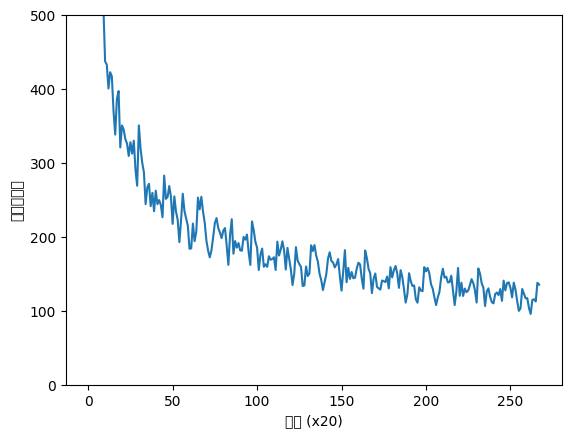

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  156.39014303677098


In [20]:
config.GPU = True # gpu 활용

# hyper parameter
batch_size = 20
wordvec_size = 100
hidden_size = 100  # lstm hidden state
time_size = 35  # lstm input words
lr = 20.0
max_epoch = 4
max_grad = 0.25 # gradient clipping

# data load
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = GRUlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

model.save_params('gru.pkl')